In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

# conda install matplotlib
# pip install sklearn
# conda install PIL
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [6]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

In [7]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [8]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [5]:
import random
random.sample(train_folders, 3)

['notMNIST_large/B', 'notMNIST_large/G', 'notMNIST_large/J']

In [45]:
# http://matplotlib.org/1.3.1/api/pyplot_api.html#matplotlib.pyplot.imshow
# http://matplotlib.org/examples/color/colormaps_reference.html
import random
import matplotlib.image as mpimg
def sample_images(folder_name, max_image_count):
    if os.path.isdir(folder_name):
        count = 0
        files = os.listdir(folder_name)
        f,ax = plt.subplots(1,max_image_count)
        title = os.path.split(folder_name)[-1]
        sampled_images = random.sample(files, max_image_count)
        for i in range(0, max_image_count):
            image_file = sampled_images[i]
            full_file_name = os.path.join(folder_name, image_file)
            image = mpimg.imread(full_file_name)
            ax[i].set_title(title)
            ax[i].imshow(image)
        f.show()

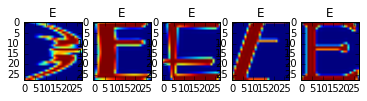

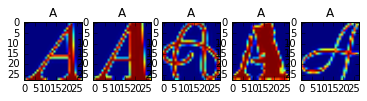

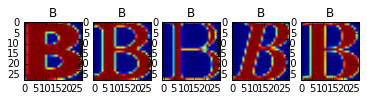

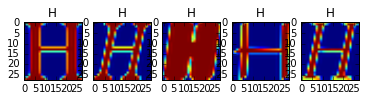

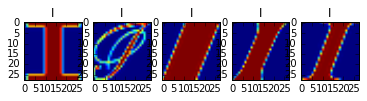

In [48]:
for folder in random.sample(train_folders, 5):
    sample_images(folder, 5)

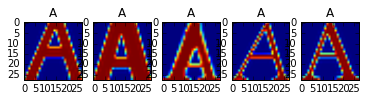

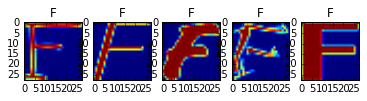

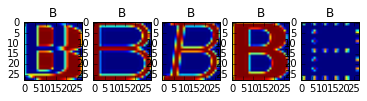

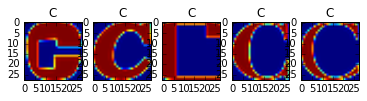

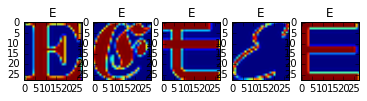

In [49]:
for folder in random.sample(test_folders, 5):
    sample_images(folder, 5)

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_large/C.pickle.
notMNIST_large/C
Full dataset tensor: (52912, 28, 28)
Mean: -0.142258
Standard deviation: 0.439806
Pickling notMNIST_large/D.pickle.
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : canno

In [11]:
dataset_A = 0
with open('notMNIST_small/A.pickle', 'rb') as f:
    dataset_A = pickle.load(f)

In [18]:
image_count, image_wdth, image_height = dataset_A.shape

In [14]:
ndimage.imread('notMNIST_small/A/SWNvbmUgTFQgUmVndWxhciBJdGFsaWMgT3NGLnR0Zg==.png')

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   2,   0, 185, 255, 251, 255,  66,   0,   2,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          2,   1,  31, 242, 254, 251, 255,  96,   0,   4,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          3,   0, 135, 255, 250, 251, 255, 136,   0,   4,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,
          1,  24, 236, 254, 255, 252, 255, 189,   0,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0, 142, 255, 251, 226, 253, 255, 233,  15,   0,   1,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   1,
         41, 246, 254, 195,  81, 255, 252, 254,  61,   0,   3,   0,   0,
          0,   0],
       [  

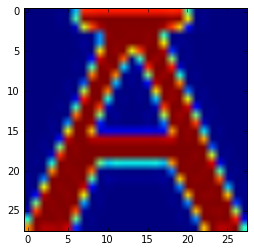

In [16]:
f, ax = plt.subplots(1,1)
ax.imshow(dataset_A[3, :, :])

In [33]:
import random
def sample_dataset(d, k):
    f, ax = plt.subplots(1,k)
    i = 0
    for image_index in random.sample(range(0, image_count), k):  
        ax[i].imshow(d[image_index, :, :])
        i += 1

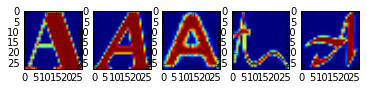

In [34]:
sample_dataset(dataset_A, 5)

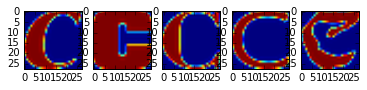

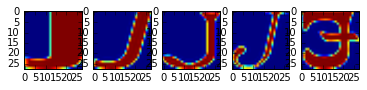

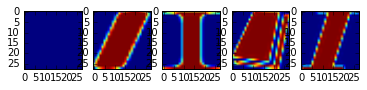

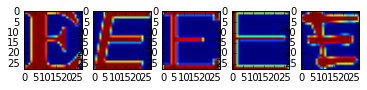

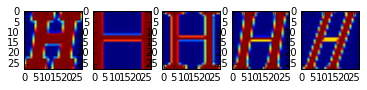

In [35]:
for folder in random.sample(test_folders, 5):
    sample_dataset(pickle.load(open(folder + '.pickle', 'rb')), 5)

In [65]:
for folder in random.sample(test_folders, 5):
    d = pickle.load(open(folder + '.pickle', 'rb'))
    image_count, image_wdth, image_height = d.shape
    letter = os.path.split(folder)[-1]
    s = "%s: %d %0.05f %0.05f" % (letter, image_count, np.mean(d), np.std(d))
    print(s)

H: 1872 -0.05869 0.45876
D: 1873 -0.04922 0.45976
J: 1872 -0.15169 0.44801
I: 1872 0.05265 0.47189
B: 1873 0.00536 0.45712


In [66]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [67]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

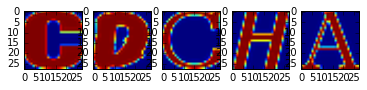

In [70]:
sample_dataset(train_dataset, 5)

In [98]:
def sample_labeled_dataset(d, l, k):
    image_count, _, _ = d.shape
    f, ax = plt.subplots(1,k)
    i = 0
    for index in random.sample(range(0, image_count), k):
        ax[i].set_title(chr(ord('A') + l[index]))
        ax[i].imshow(d[index, :, :])
        i += 1

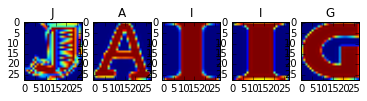

In [99]:
sample_labeled_dataset(train_dataset, train_labels, 5)

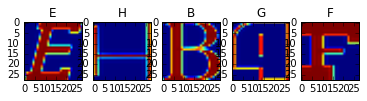

In [100]:
sample_labeled_dataset(test_dataset, test_labels, 5)

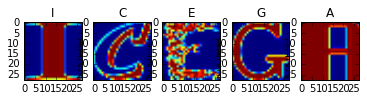

In [101]:
sample_labeled_dataset(valid_dataset, valid_labels, 5)

In [102]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [103]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441
